# Trajectory Optimization for a planar walker

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)
import importlib
from direct_col_dev import find_throwing_trajectory

meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7001


In [2]:
from dataclasses import dataclass
from pydrake.multibody.tree import Frame

@dataclass
class PointOnFrame:
    frame: Frame
    pt: np.ndarray

def get_foot_pos(context, plant):
    contact_points = {
    0: PointOnFrame(
        plant.GetBodyByName("left_lower_leg").body_frame(),
        np.array([0, 0, -0.5])
    ),
    1: PointOnFrame(
        plant.GetBodyByName("right_lower_leg").body_frame(),
        np.array([0, 0, -0.5])
    )
    }
    ft = np.zeros((3,2))
    i =0
    for fsm in [0,1]:
        pt_to_track = contact_points[fsm]
        ft[:,i] = plant.CalcPointsPositions(context, pt_to_track.frame,
                                        pt_to_track.pt, plant.world_frame()).ravel()
        i+=1
    return ft    


## Run trajectory optimization to find the optimal trajectory

In [3]:
N = 30
initial_state = np.zeros(14)
q = np.zeros((7,))
# q[0] = 0; q[1] = 0.6
# theta = -np.arccos(q[1])
# q[3] = theta; q[4] = -2 * theta
# q[5] = theta;   q[6] = -2 * theta


q = np.zeros((7,))
q[0] = 0; q[1] = 1
theta = -np.arccos(q[1])
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
initial_state[:7] = q

final_state = initial_state
# final_configuration = np.array([np.pi, 0])
tf = 1/2
x_traj, u_traj, prog,  _, _ = find_throwing_trajectory(N, initial_state, 0.2, tf=tf, jumpheight_tol=5e-2)


Starting the solve
optimal cost:  1991299.4107640414
x_sol:  [[ 0.0000e+00  1.0000e+00 -0.0000e+00 -0.0000e+00 -0.0000e+00  0.0000e+00
  -0.0000e+00 -0.0000e+00 -0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  -0.0000e+00  0.0000e+00]
 [-0.0000e+00  1.0000e+00  0.0000e+00 -1.4000e-01  2.7000e-01 -1.0000e-02
   3.0000e-02 -1.8000e-01 -1.5000e-01 -4.6000e-01 -1.6010e+01  3.0710e+01
  -1.3600e+00  2.5100e+00]
 [-0.0000e+00  9.9000e-01 -0.0000e+00 -3.5000e-01  3.1000e-01 -3.0000e-02
   4.0000e-02 -1.3000e-01 -3.0000e-01 -4.0000e-01 -6.1300e+00 -9.5700e+00
  -6.8000e-01 -4.6000e-01]
 [-1.0000e-02  9.9000e-01 -0.0000e+00 -3.8000e-01  2.4000e-01 -1.6000e-01
   4.7000e-01 -3.0000e-02  4.3000e-01  1.6000e-01 -2.1700e+00  4.3800e+00
  -8.3400e+00  2.6610e+01]
 [-1.0000e-02  1.0000e+00  0.0000e+00 -4.6000e-01  3.7000e-01 -1.8000e-01
   3.8000e-01 -1.2000e-01  2.7000e-01 -3.0000e-01 -4.7500e+00  7.8000e-01
  -3.7200e+00 -2.3900e+00]
 [-1.0000e-02  1.0000e+00 -0.0000e+00 -5.3000e-01  2.9000e-01 -3

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [4]:
from pydrake.all import AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction, MeshcatVisualizerParams, ConstantValueSource
# Create a MultibodyPlant for the arm
file_name = "/home/anirudhkailaje/Documents/01_UPenn/02_MEAM5170/03_FinalProject/src/planar_walker.urdf"

builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
parser = Parser(plant)
parser.AddModels(file_name)
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()

n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()

# x_traj_mod = np.zeros((n))
x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), plant.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
# builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

# MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

vis_params = MeshcatVisualizerParams(publish_period=0.0005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)



diagram = builder.Build()
diagram.set_name("diagram")

simulator = Simulator(diagram)
simulator.Initialize()
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())

plant.SetPositions(plant_context, q)



  
# simulator.set_target_realtime_rate(.1)
# simulator.AdvanceTo(1);
timesteps = np.linspace(0, tf, 1000)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  u = np.linalg.norm(u_traj.vector_values([t]))
  plant.SetPositionsAndVelocities(plant_context, x)
  com_pos = plant.CalcCenterOfMassPositionInWorld(plant_context).ravel()
  com_pos_list.append(com_pos)
#   ft = np.min(get_foot_pos(plant_context, plant)[-1,:])
#   vel_list.append(ft)

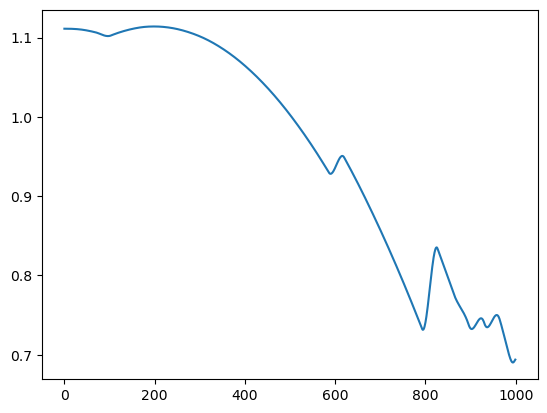

In [5]:
# fig = plt.figure()
# plt.plot(timesteps, com_pos_list[:][2])
# plt.plot(timesteps,vel_list)
# plt.show()

np.save('com.npy', np.array(com_pos_list))
plt.plot(np.array(com_pos_list)[:,2])

In [6]:
TrajectorySource(x_traj)

from pydrake.all import LeafSystem, AbstractValue
class tmp(LeafSystem):
    def __init__(self, x_traj):
        super().__init__()
        self.com_traj_output_port_index = self.DeclareAbstractOutputPort(
            "com_traj", 
            lambda: AbstractValue.Make(PiecewisePolynomial()),
            self.CalcComTraj
        ).get_index()
        self.x_traj = x_traj
    
    def CalcComTraj(self, context, output):
        output.set_value(self.x_traj)




In [7]:
#Start the meshcat server
builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
parser = Parser(plant)
parser.AddModels("../models/planar_walker.urdf")
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()
import osc_modified
import osc_tracking_objective
importlib.reload(osc_modified)
importlib.reload(osc_tracking_objective)
from osc_modified import OperationalSpaceWalkingController
#### Designing the controller ####
zdes = 1.5 #desired Z height in meters
z_height_desired = builder.AddSystem(ConstantVectorSource(np.array([zdes])))
base_traj_src = builder.AddSystem(
    ConstantValueSource(AbstractValue.Make(PiecewisePolynomial(np.zeros(1,))))
)
x_traj_source = builder.AddSystem(tmp(x_traj))
# preflight_planner = builder.AddSystem(dircol())
osc = builder.AddSystem(OperationalSpaceWalkingController(0))

#DIRCOL OUT -> OSC IN
builder.Connect(x_traj_source.get_output_port(), osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), osc.get_traj_input_port("base_joint_traj"))
builder.Connect(plant.get_state_output_port(), osc.get_state_input_port()) 
builder.Connect(osc.torque_output_port, plant.get_actuation_input_port())
from pydrake.all import LogVectorOutput
logger = LogVectorOutput(osc.GetOutputPort("metrics"),builder, publish_period=0.01)

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

#simulate
diagram = builder.Build()


sim_time = tf
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(0.1)

# State Description: q = [x, z, planar_roty, left_hip, left_knee, right_hip, right_knee]
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())


# initial_state= np.zeros((  14,))
# q = np.zeros((7,))


plant.SetPositions(plant_context, q)

# Simulate the robot
simulator.AdvanceTo(0.8)

## Logs and Plots ##


chel
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal!!!
Solver not working, pal

In [ ]:
log = logger.FindLog(simulator.get_mutable_context()) #xyz vxvyvz
t = log.sample_times()
x = log.data()[2]   
xdot = log.data()[-1]

plt.figure()
plt.plot(t[2:-10], x[2:-10])
plt.figure()
plt.plot(t, xdot)
# plt.savefig(f"./logs/{time}plots.png")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>